In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [4]:
class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=128):
        super(NerfModel, self).__init__()

        self.block1 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        # density estimation
        self.block2 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1), )
        # color estimation
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos)
        emb_d = self.positional_encoding(d, self.embedding_dim_direction)
        h = self.block1(emb_x)
        tmp = self.block2(torch.cat((h, emb_x), dim=1))
        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1])
        h = self.block3(torch.cat((h, emb_d), dim=1))
        c = self.block4(h)
        return c, sigma


model = NerfModel(hidden_dim=256).cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/nerf.pt'))
model.eval()

NerfModel(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=257, bias=True)
  )
  (block3): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
  )
  (block4): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
    (1): Sigmoid()
  )
  (relu): ReLU()
)

In [5]:
@torch.no_grad()
def test(dataset, model, hn, hf, chunk_size=10, img_index=0, nb_bins=192, H=400, W=400):
    """
    Args:
        hn: near plane distance
        hf: far plane distance
        dataset: dataset to render
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        img_index (int, optional): image index to render. Defaults to 0.
        nb_bins (int, optional): number of bins for density estimation. Defaults to 192.
        H (int, optional): image height. Defaults to 400.
        W (int, optional): image width. Defaults to 400.

    Returns:
        None: None
    """

    device = 'cuda'

    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    data = []
    for i in range(int(np.ceil(H / chunk_size))):

        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        regenerated_px_values = render_rays(model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins)
        data.append(regenerated_px_values)
    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

    plt.figure()
    plt.imshow(img)
    plt.savefig(f'img_{img_index}.png', bbox_inches='tight')
    plt.close()



In [6]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

In [20]:
def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    device = ray_origins.device

    batch_size = ray_origins.shape[0]

    # Sample points along the rays
    z_vals = torch.linspace(hn, hf, nb_bins, device=device)
    z_vals = z_vals.expand(batch_size, nb_bins)

    # Convert these points to world coordinates
    points = ray_origins[:, None, :] + ray_directions[:, None, :] * z_vals[..., None]
    points_flat = points.reshape(-1, 3)

    # Prepare ray directions for the model input
    ray_directions_flat = ray_directions[:, None, :].expand(batch_size, nb_bins, 3).reshape(-1, 3)

    # Query the NeRF model
    colors, densities = nerf_model(points_flat, ray_directions_flat)
    colors = colors.view(batch_size, nb_bins, 3)
    densities = densities.view(batch_size, nb_bins)

    # Compute distances between sample points
    dists = z_vals[:, 1:] - z_vals[:, :-1]
    dists = torch.cat([dists, torch.full_like(dists[:, :1], hf - hn)], dim=-1)

    # Compute alpha values (density -> alpha)
    alphas = 1.0 - torch.exp(-densities * dists)

    # Compute accumulated transmittance
    transmittance = compute_accumulated_transmittance(1.0 - alphas + 1e-10)

    # Accumulate colors along the rays
    weights = alphas * transmittance
    pixel_colors = (weights[..., None] * colors).sum(dim=1)

    return pixel_colors

In [19]:
testing_dataset = torch.from_numpy(np.load('/content/drive/MyDrive/test_data.npy', allow_pickle=True))

In [15]:
testing_dataset[0]

tensor([ 0.0000,  2.7373,  2.9593,  0.3208, -0.8406, -0.4364,  1.0000,  1.0000,
         1.0000])

In [16]:
for img_index in range(50):
  test(testing_dataset, model, hn=2, hf=6, img_index=img_index, nb_bins=192, H=400, W=400)

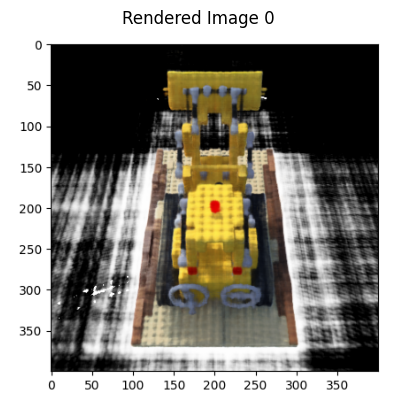

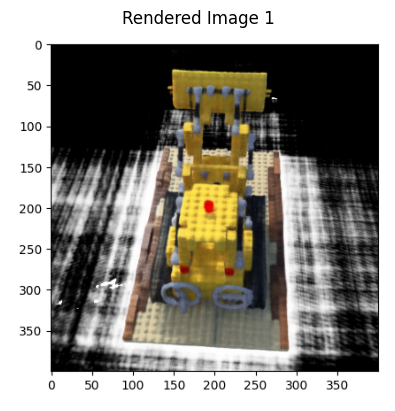

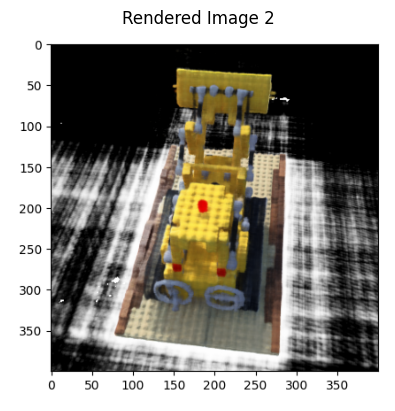

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for img_index in range(3):
    img = mpimg.imread(f'img_{img_index}.png')
    plt.figure()
    plt.imshow(img)
    plt.title(f'Rendered Image {img_index}')
    plt.axis('off')
    plt.show()
